# Challenge - Decision Tree vs. Random Forest 
## Weather - Temperature Prediction
Using this [dataset](https://www.kaggle.com/budincsevity/szeged-weather/download) from [Kaggle](https://www.kaggle.com/budincsevity/szeged-weather) that outlines weather variables in Szeged, Hungary, develop two models to predict type of weather: a Decision Tree and a Random Forest Classifier. Compare the models based on accuracy and runtime.

In [ ]:
conda install pydotplus

In [ ]:
conda install graphviz

In [1]:
# import libraries
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import pandas as pd
import seaborn as sns
import time
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

## Load the Dataset from Thinkful's Database

In [2]:
from sqlalchemy import create_engine
# Database credentials
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'weatherinszeged'

# use the credentials to start a connection
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

# Use the connection to extract SQL data
weather = pd.read_sql_query('SELECT * FROM weatherinszeged', con=engine)

#Close the connection after query is complete
engine.dispose()

In [3]:
weather.shape

(96453, 12)

In [4]:
weather.head()

,date,summary,preciptype,temperature,apparenttemperature,humidity,windspeed,windbearing,visibility,loudcover,pressure,dailysummary
0,2006-03-31 22:00:00+00:00,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-03-31 23:00:00+00:00,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 00:00:00+00:00,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 01:00:00+00:00,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 02:00:00+00:00,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.


In [5]:
weather.columns

Index(['date', 'summary', 'preciptype', 'temperature', 'apparenttemperature',
       'humidity', 'windspeed', 'windbearing', 'visibility', 'loudcover',
       'pressure', 'dailysummary'],
      dtype='object')

## Data Cleaning

In [6]:
#Split date feature into usable features: hour, day, month, and year
day = []
month = []
year = []
hour = []
for date in weather['date']:
    year.append(int(str(date).split('-')[0]))
    month.append(int(str(date).split('-')[1]))
    day.append(int(str(date).split('-')[2].split(' ')[0]))
    hour.append(int(str(date).split(' ')[1].split(':')[0]))
    
weather['year'] = year
weather['month'] = month
weather['day'] = day
weather['hour'] = hour


#Convert precipitation type to dummy
unique_ptype = list(np.unique(weather['preciptype']))
# ['null', 'rain', 'snow']
dummy_ptype = []
for row in weather['preciptype']:
    for i in range(len(unique_ptype)):
        if row == unique_ptype[i]:
            dummy_ptype.append(i)
        
weather['preciptype'] = dummy_ptype

In [7]:
#Drop columns that are not useful for regression
weather = weather.drop(['date', 'loudcover', 'dailysummary', 'apparenttemperature'], axis = 1)

In [25]:
print(np.unique(weather['summary']))
print(len(np.unique(weather['summary'])))

['Breezy' 'Breezy and Dry' 'Breezy and Foggy' 'Breezy and Mostly Cloudy'
 'Breezy and Overcast' 'Breezy and Partly Cloudy' 'Clear'
 'Dangerously Windy and Partly Cloudy' 'Drizzle' 'Dry'
 'Dry and Mostly Cloudy' 'Dry and Partly Cloudy' 'Foggy'
 'Humid and Mostly Cloudy' 'Humid and Overcast' 'Humid and Partly Cloudy'
 'Light Rain' 'Mostly Cloudy' 'Overcast' 'Partly Cloudy' 'Rain' 'Windy'
 'Windy and Dry' 'Windy and Foggy' 'Windy and Mostly Cloudy'
 'Windy and Overcast' 'Windy and Partly Cloudy']
27


In [45]:
orig_weather = weather.copy()

In [58]:
weather = orig_weather.copy()

In [60]:
#Simplify summary terms to simplify the model
summary = []
for item in weather['summary']:
    if 'and' in item.split(' '):
        summary.append(item.split(' and ')[0])
    else:
        summary.append(item)

print(np.unique(summary))
print(len(np.unique(summary)))


summary2 = []
for item in summary:
    if 'Partly' in item.split(' '):
        summary2.append(item.replace('Partly ', ''))
    elif 'Mostly' in item.split(' '):
        summary2.append(item.replace('Mostly ', ''))
    elif 'Dangerously' in item.split(' '):
        summary2.append(item.replace('Dangerously ', ''))
    elif 'Light' in item.split(' '):
        summary2.append(item.replace('Light ', ''))
    else:
        summary2.append(item)

print(np.unique(summary2))
print(len(np.unique(summary2)))

#To simplify even more, combine 'Breezy' with 'Windy', 'Drizzle' with 'Rain', and 'Overcast' with 'Cloudy'
summary3 = []
for item in summary2:
    if item == 'Breezy':
        summary3.append('Windy')
    elif item == 'Drizzle':
        summary3.append('Rain')
    elif item == 'Overcast':
        summary3.append('Cloudy')
    else:
        summary3.append(item)

print(np.unique(summary3))
print(len(np.unique(summary3)))

weather['summary'] = summary3

['Breezy' 'Clear' 'Dangerously Windy' 'Drizzle' 'Dry' 'Foggy' 'Humid'
 'Light Rain' 'Mostly Cloudy' 'Overcast' 'Partly Cloudy' 'Rain' 'Windy']
13
['Breezy' 'Clear' 'Cloudy' 'Drizzle' 'Dry' 'Foggy' 'Humid' 'Overcast'
 'Rain' 'Windy']
10
['Clear' 'Cloudy' 'Dry' 'Foggy' 'Humid' 'Rain' 'Windy']
7


In [42]:
[item for item in summary if 'Light' in item.split(' ') ]

['Dangerously Windy and Partly Cloudy']

In [61]:
y = [x.split(' and ') for x in np.unique(weather['summary'])]
flaty = [item for sublist in y for item in sublist]
summary_terms = list(np.unique(flaty))

summary_terms

['Clear', 'Cloudy', 'Dry', 'Foggy', 'Humid', 'Rain', 'Windy']

## Initial Visualization/ Feature Selection

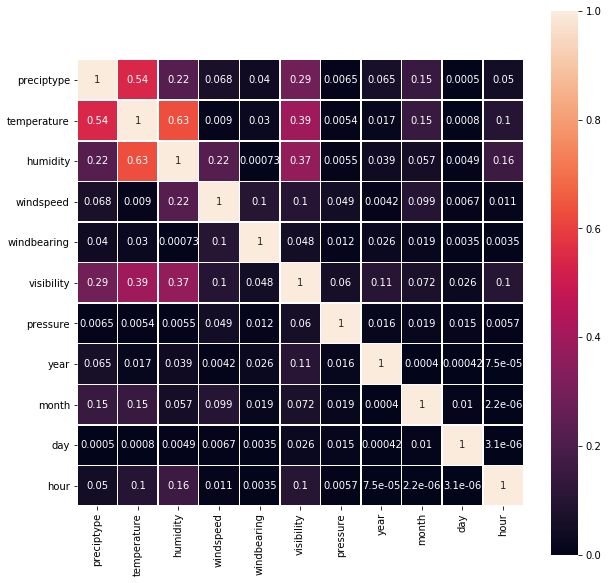

In [62]:
#Find the correlation between the existing features to see if we need to drop any
plt.figure(figsize=(10,10))
sns.heatmap(abs(weather.corr()), square=True, linewidths=.5, annot=True)
plt.show()

In [63]:
#Summary is the target variable, everything else is a feature
features = weather.drop('summary', axis=1)
target = weather['summary']

## Train-Test Split

In [64]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=20)

## Decision Tree

In [70]:
# Initialize and train the tree
start = time.time()
decision_tree = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_features=1,
    max_depth=7,
    random_state = 1337
)
decision_tree.fit(X_train, y_train)

decision_tree_scores = cross_val_score(decision_tree, X_test, y_test, cv=10)

accuracy = decision_tree_scores.mean()
print("Accuracy Score: {}".format(accuracy))

runtime = time.time() - start
print("Runtime: {} seconds".format(runtime))

Accuracy Score: 0.8367190414054532
Runtime: 3.0963714122772217 seconds


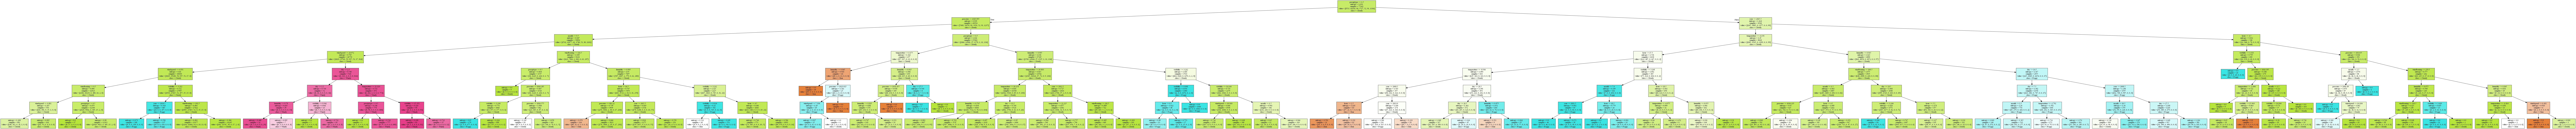

In [71]:
#Visualize the decision tree
from IPython.display import Image
import pydotplus
import graphviz

dot_data = tree.export_graphviz(
    decision_tree, out_file=None,
    feature_names=features.columns,
    class_names=list(np.unique(weather['summary'])),
    filled=True
)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

## Random Forest

In [72]:
start = time.time()

rf = RandomForestClassifier(criterion="entropy", random_state=1337)
rf.fit(X_train, y_train)

rf_scores = cross_val_score(rf, X_test, y_test, cv=5)

accuracy = rf_scores.mean()
print("Accuracy: {}".format(accuracy))

runtime = time.time() - start
print("Runtime: {} seconds".format(runtime))

Accuracy: 0.8903119567946678
Runtime: 11.840341806411743 seconds


The Random Forest classifier had a runtime of 4 times the length of the tree model. However, it increased the accuracy of the model by about 5%, which may be a worthwhile tradeoff in many situations, especially if the dataset is on a relatively small scale.